# Generating density map


In [1]:
#imports
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
import tqdm
import scipy
import cv2
import scipy.io as io 
from keras import backend as K
from keras.models import model_from_json
from keras.utils import load_img, img_to_array
from matplotlib import cm as c
from keras.models import Model, Sequential
from keras.layers import Conv2D, Dense, Input, Flatten, MaxPooling2D, BatchNormalization, Activation, UpSampling2D
from keras import optimizers
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.initializers import RandomNormal 

/tmp/ipykernel_5133/389678396.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
2022-11-26 13:02:54.387005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 13:02:55.533811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tithi/.pyenv/versions/3.8.12/envs/ICYO/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-26 13:02:55.533868: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above 

In [2]:
# function to create density maps for images
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

#Creating file path

In [3]:
root='/home/tithi/code/RakshitTithi/ICYO/'

In [4]:
part_A_train=os.path.join(root,'raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data','images')
part_A_test = os.path.join(root,'raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/test_data','images')
part_B_train = os.path.join(root,'raw_data/Shaghaitech_dataset/ShanghaiTech/part_B/train_data','images')
part_B_test = os.path.join(root,'raw_data/Shaghaitech_dataset/ShanghaiTech/part_B/test_data','images')
path_sets = [part_A_train,part_A_test]

In [5]:
part_A_train

'/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data/images'

#create a list of absolute path of jpg file

In [6]:
img_paths=[]
for path in path_sets:
    for img_path in sorted(glob.glob(os.path.join(path,'*.jpg'))):
        img_paths.append(img_path)
        

In [7]:
img_paths=img_paths[:25]
img_paths

['/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data/images/IMG_1.jpg',
 '/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data/images/IMG_10.jpg',
 '/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data/images/IMG_100.jpg',
 '/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data/images/IMG_101.jpg',
 '/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data/images/IMG_102.jpg',
 '/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data/images/IMG_103.jpg',
 '/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data/images/IMG_104.jpg',
 '/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data/images/IMG_105.jpg',
 '/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_d

#creating density map

In [8]:
from tqdm import tqdm

i = 0
for img_path in tqdm(img_paths):
        
    
    # Load sparse matrix
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    #Read image
    img= plt.imread(img_paths[0])

    # Create a zero matrix of image size
    k = np.zeros((img.shape[0],img.shape[1]))

    gt = mat["image_info"][0,0][0,0][0]

    #Generate hot encoded matrix of sparse matrix
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1

    # generate density map
    k = gaussian_filter_density(k)

    # File path to save density map
    file_path = img_path.replace('.jpg','.h5').replace('images','ground-truth')


    with h5py.File(file_path, 'w') as hf:
            hf['density'] = k

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_5133/4212836471.py:24: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')


(768, 1024)
generate density...


  4%|███▉                                                                                             | 1/25 [00:42<16:58, 42.43s/it]

done.
(768, 1024)
generate density...


  8%|███████▊                                                                                         | 2/25 [01:22<15:45, 41.10s/it]

done.
(768, 1024)
generate density...


 12%|███████████▋                                                                                     | 3/25 [01:40<11:14, 30.65s/it]

done.
(768, 1024)
generate density...


 16%|███████████████▌                                                                                 | 4/25 [01:57<08:47, 25.14s/it]

done.
(768, 1024)
generate density...


 20%|███████████████████▍                                                                             | 5/25 [02:10<06:53, 20.66s/it]

done.
(768, 1024)
generate density...


 24%|███████████████████████▎                                                                         | 6/25 [02:15<04:52, 15.39s/it]

done.
(768, 1024)
generate density...


 28%|███████████████████████████▏                                                                     | 7/25 [02:29<04:26, 14.83s/it]

done.
(768, 1024)
generate density...


 32%|███████████████████████████████                                                                  | 8/25 [02:44<04:15, 15.06s/it]

done.
(768, 1024)
generate density...


 36%|██████████████████████████████████▉                                                              | 9/25 [03:15<05:22, 20.13s/it]

done.
(768, 1024)
generate density...


 40%|██████████████████████████████████████▍                                                         | 10/25 [03:24<04:10, 16.70s/it]

done.
(768, 1024)
generate density...


 44%|██████████████████████████████████████████▏                                                     | 11/25 [04:05<05:36, 24.01s/it]

done.
(768, 1024)
generate density...


 48%|██████████████████████████████████████████████                                                  | 12/25 [04:37<05:44, 26.51s/it]

done.
(768, 1024)
generate density...


 52%|█████████████████████████████████████████████████▉                                              | 13/25 [04:49<04:25, 22.13s/it]

done.
(768, 1024)
generate density...


 56%|█████████████████████████████████████████████████████▊                                          | 14/25 [05:04<03:40, 20.04s/it]

done.
(768, 1024)
generate density...


 60%|█████████████████████████████████████████████████████████▌                                      | 15/25 [05:48<04:31, 27.16s/it]

done.
(768, 1024)
generate density...


 64%|█████████████████████████████████████████████████████████████▍                                  | 16/25 [07:03<06:14, 41.60s/it]

done.
(768, 1024)
generate density...


 68%|█████████████████████████████████████████████████████████████████▎                              | 17/25 [07:26<04:47, 35.98s/it]

done.
(768, 1024)
generate density...


 72%|█████████████████████████████████████████████████████████████████████                           | 18/25 [07:40<03:25, 29.30s/it]

done.
(768, 1024)
generate density...


 76%|████████████████████████████████████████████████████████████████████████▉                       | 19/25 [08:01<02:40, 26.73s/it]

done.
(768, 1024)
generate density...


 80%|████████████████████████████████████████████████████████████████████████████▊                   | 20/25 [08:32<02:20, 28.01s/it]

done.
(768, 1024)
generate density...


 84%|████████████████████████████████████████████████████████████████████████████████▋               | 21/25 [08:55<01:46, 26.72s/it]

done.
(768, 1024)
generate density...


 88%|████████████████████████████████████████████████████████████████████████████████████▍           | 22/25 [10:09<02:02, 40.84s/it]

done.
(768, 1024)
generate density...


 92%|████████████████████████████████████████████████████████████████████████████████████████▎       | 23/25 [10:34<01:12, 36.05s/it]

done.
(768, 1024)
generate density...


 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 24/25 [10:57<00:32, 32.25s/it]

done.
(768, 1024)
generate density...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [11:58<00:00, 28.75s/it]

done.


In [9]:
file_path = img_paths[0].replace('.jpg','.h5').replace('images','ground-truth') 
print(file_path)

/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data/ground-truth/IMG_1.h5


Sum =  1543.841


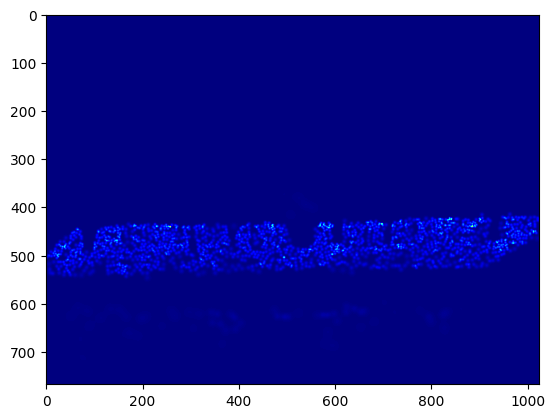

In [10]:
#Sample Ground Truth
gt_file = h5py.File(file_path,'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)
Sum=np.sum(groundtruth)
print("Sum = " ,Sum)

/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data/images/IMG_1.jpg


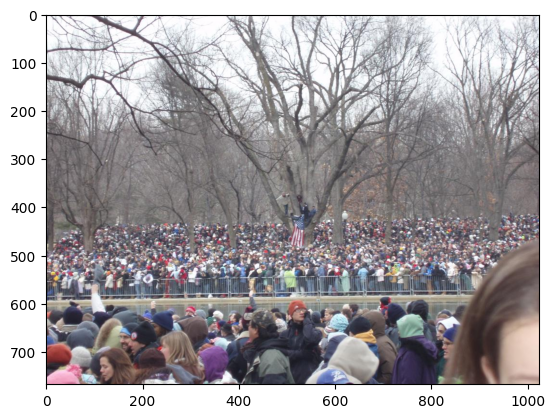

In [11]:
img = Image.open(file_path.replace('.h5','.jpg').replace('ground-truth','images'))
plt.imshow(img)
print(file_path.replace('.h5','.jpg').replace('ground-truth','images'))

#Model

In [12]:
K.clear_session()
root='/home/tithi/code/RakshitTithi/ICYO/'

In [13]:
part_A_train=os.path.join(root,'raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data','images')
part_A_test = os.path.join(root,'raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/test_data','images')
part_B_train = os.path.join(root,'raw_data/Shaghaitech_dataset/ShanghaiTech/part_B/train_data','images')
part_B_test = os.path.join(root,'raw_data/Shaghaitech_dataset/ShanghaiTech/part_B/test_data','images')
temp = 'test_images'
path_sets = [part_A_train]

In [14]:
img_paths = []

for path in path_sets:
    
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        
        img_paths.append(str(img_path))
        
print("Total images : ",len(img_paths))


Total images :  300


In [15]:
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225

    #print(im.shape)
    #im = np.expand_dims(im,axis  = 0)
    return im

def get_input(path):
    path = path[0] 
    img = create_img(path)
    return(img)

def get_output(path):
    #import target
    #resize target
    
    gt_file = h5py.File(path,'r')
    
    target = np.asarray(gt_file['density'])
    
    img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    
    img = np.expand_dims(img,axis  = 3)
    
    #print(img.shape)
    
    return img
    
    
    
def preprocess_input(image,target):
    #crop image
    #crop target
    #resize target
    crop_size = (int(image.shape[0]/2),int(image.shape[1]/2))
    
    
    if random.randint(0,9)<= -1:            
            dx = int(random.randint(0,1)*image.shape[0]*1./2)
            dy = int(random.randint(0,1)*image.shape[1]*1./2)
    else:
            dx = int(random.random()*image.shape[0]*1./2)
            dy = int(random.random()*image.shape[1]*1./2)

    #print(crop_size , dx , dy)
    img = image[dx : crop_size[0]+dx , dy:crop_size[1]+dy]
    
    target_aug = target[dx:crop_size[0]+dx,dy:crop_size[1]+dy]
    #print(img.shape)

    return(img,target_aug)
    

In [16]:
#Image data generator 
def image_generator(files, batch_size = 64):
    
    while True:
        
        input_path = np.random.choice(a = files, size = batch_size)
        
        batch_input = []
        batch_output = [] 
          
#         for input_path in batch_paths:

        inputt = get_input(input_path )
        output = get_output(input_path[0].replace('.jpg','.h5').replace('images','ground-truth') )


        batch_input += [inputt]
        batch_output += [output]


        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )

        yield( batch_x, batch_y )

In [17]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    
    model_json = model.to_json()
    
    with open(str2, "w") as json_file:
        json_file.write(model_json)

In [18]:
def init_weights_vgg(model):
    #vgg =  VGG16(weights='imagenet', include_top=False)
    
    json_file = open('models/VGG_16.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("weights/VGG_16.h5")
      
    
    vgg = loaded_model
    
    vgg_weights=[]                         
    for layer in vgg.layers:
        if('conv' in layer.name):
            vgg_weights.append(layer.get_weights())
    
    
    offset=0
    i=0
    while(i<10):
        if('conv' in model.layers[i+offset].name):
            model.layers[i+offset].set_weights(vgg_weights[i])
            i=i+1
            #print('h')
            
        else:
            offset=offset+1

    return (model)
    

In [19]:
def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function) 
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [20]:
# Neural network model : VGG + Conv
def CrowdNet():  
            #Variable Input Size
            rows = None
            cols = None
            
            #Batch Normalisation option
            
            batch_norm = 0
            kernel = (3, 3)
            init = RandomNormal(stddev=0.01)
            model = Sequential() 
            
            #custom VGG:
            
            if(batch_norm):
                model.add(Conv2D(64, kernel_size = kernel, input_shape = (rows,cols,3),activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                
            else:
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same',input_shape = (rows, cols, 3), kernel_initializer = init))
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                
                

                
            #Conv2D
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
        
            sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
            model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
            
            model = init_weights_vgg(model)
            
            return model

In [21]:
model = CrowdNet()

2022-11-26 13:14:59.985335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tithi/.pyenv/versions/3.8.12/envs/ICYO/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-26 13:14:59.990629: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-26 13:14:59.990939: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-FLJOLQ6E): /proc/driver/nvidia/version does not exist
2022-11-26 13:15:00.013281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

In [22]:
!ls weights

model_A_weights.h5  VGG_16.h5


In [23]:
img_path_train=img_paths[:25]
len(img_path_train)

25

In [24]:
train_gen = image_generator(img_path_train,1)

In [25]:
sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])

In [26]:
model.fit(train_gen,epochs=1,steps_per_epoch= 700 , verbose=1)


AxisError: axis 3 is out of bounds for array of dimension 3

In [ ]:
# save_mod(model,"weights/model_A_weights.h5","models/Model.json")

#Inference

In [27]:
def load_model():
    # Function to load and return neural network model 
    json_file = open('models/Model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("weights/model_A_weights.h5")
    return loaded_model

def create_img(path):
    #Function to load,normalize and return image 
    print(path)
    im = Image.open(path).convert('RGB')
    
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225


    im = np.expand_dims(im,axis  = 0)
    return im

In [28]:
def predict(path):
    #Function to load image,predict heat map, generate count and return (count , image , heat map)
    model = load_model()
    image = create_img(path)
    ans = model.predict(image)
    count = np.sum(ans)
    return count,image,ans

In [29]:
img_paths[0]

'/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data/images/IMG_131.jpg'

In [34]:
ans,img,hmap = predict('raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/test_data/images/IMG_100.jpg')

raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/test_data/images/IMG_100.jpg
1/1 [==============================] - 4s 4s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


365.8236


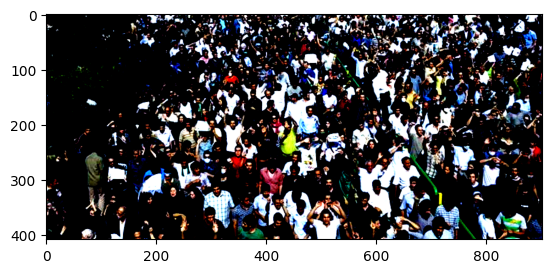

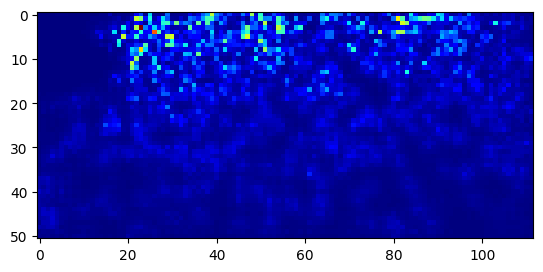

In [35]:
print(ans)
#Print count, image, heat map
plt.imshow(img.reshape(img.shape[1],img.shape[2],img.shape[3]))
plt.show()
plt.imshow(hmap.reshape(hmap.shape[1],hmap.shape[2]) , cmap = c.jet )
plt.show()

In [38]:
temp = h5py.File('raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/test_data/images/IMG_100.h5' , 'r')
# temp =plt.imshow('raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/test_data/images/IMG_100.h5' )
temp_1 = np.asarray(temp['density'])
#plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/test_data/images/IMG_100.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [40]:
!ls weights

model_A_weights.h5  VGG_16.h5
